In [51]:
# Import required libraries.
import  tensorflow as tf
import  keras

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from    keras.utils import to_categorical
from    keras.callbacks import EarlyStopping

# Helper libraries.
import  numpy as np
import  sklearn
from    sklearn.model_selection import train_test_split

# Libraries for plotting.
import  matplotlib
import  matplotlib.pyplot as plt
from    PIL import Image
from    IPython.display import display

# Other
import gc

In [52]:
# Code taken from Lab #1.
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.

import sys

IN_COLAB = 'google.colab' in sys.modules

if not tf.config.list_physical_devices('GPU'):
	print("No GPU was detected. CNNs can be very slow without a GPU.")
	if IN_COLAB:
		print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
	os.system('nvidia-smi -L')

No GPU was detected. CNNs can be very slow without a GPU.


In [53]:
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

No GPU detected.


In [54]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [55]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


In [56]:
import zipfile

# Function to load a ZIP file from Google Drive.
def load_zip_file(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract to a specific directory
            zip_ref.extractall('/content/Model/dataset')
            print(f"ZIP file '{zip_path}' loaded successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at '{zip_path}'.")
    except zipfile.BadZipFile:
        print(f"Error: Invalid ZIP file at '{zip_path}'.")

# If in Colab, load the ZIP file from Google Drive.
if IN_COLAB:
    print("Loading and extracting dataset ZIP-file form Drive.")
    load_zip_file("drive/MyDrive/Studies/KTH/Courses/II143X/Model Creation/Data/output_frames.zip")
else:
    print("No Colab detected, using pre-existing files.")

extracted_path = "dataset"

No Colab detected, using pre-existing files.


In [57]:
"""
1. Extract the data from the dataset (The dataset is of format [ [x,y,z], [i,j,k]])
2. Use numpy to extract the data into a numpy array.
 
3.
"""
dataset_classes = []
dataset_array = []

# Loop class folders
for directory in os.listdir(extracted_path): 
    # Grab class folder path
    directory_path = os.path.join(extracted_path, directory)
    # Store class in array (same name as folder)
    dataset_classes.append(directory)
    # Prepare class entires array
    class_entires = []    
    # Loop files in class folder
    for file in os.listdir(directory_path):
        # Grab file path
        file_path = os.path.join(directory_path, file)
        with open(file_path, "r") as file_data:
            # Parsing the data into a list
            mfcc_txt = file_data.read()
            mfcc_data = np.array(eval(mfcc_txt)).T
            class_entires.append(mfcc_data)
    # Append class entires to dataset array
    dataset_array.append(class_entires)

In [58]:
print(dataset_classes)
print(dataset_array[0])

['church_bells', 'chirping_birds', 'chainsaw']
[array([[-5.67793274e+02, -6.65020691e+02, -6.78516846e+02,
        -6.76892334e+02, -6.64840271e+02, -6.73924072e+02,
        -6.59997131e+02, -6.91631897e+02, -6.99850830e+02,
        -6.55131836e+02, -6.64773926e+02, -6.58293213e+02,
        -6.45461121e+02, -6.56085999e+02, -6.61020996e+02,
        -6.84032837e+02, -6.51479614e+02, -6.37963318e+02,
        -6.23043152e+02, -6.47079102e+02, -6.75799438e+02,
        -6.81356201e+02, -6.65316833e+02, -6.58610718e+02,
        -6.50640381e+02, -6.27453308e+02, -6.11642334e+02,
        -6.10571289e+02, -6.37163391e+02, -6.32915222e+02,
        -6.42467468e+02, -6.51234436e+02, -6.61645264e+02,
        -6.67490479e+02, -6.58440186e+02, -6.81035828e+02,
        -6.88191345e+02, -6.94229858e+02, -6.94117554e+02,
        -7.07509827e+02, -7.31564087e+02, -7.11369446e+02,
        -7.34461365e+02, -7.29195496e+02, -7.16450195e+02,
        -7.41994995e+02, -7.36455627e+02, -7.59260681e+02,
        

In [59]:
import librosa

def plot_mfcc(mfccs):
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

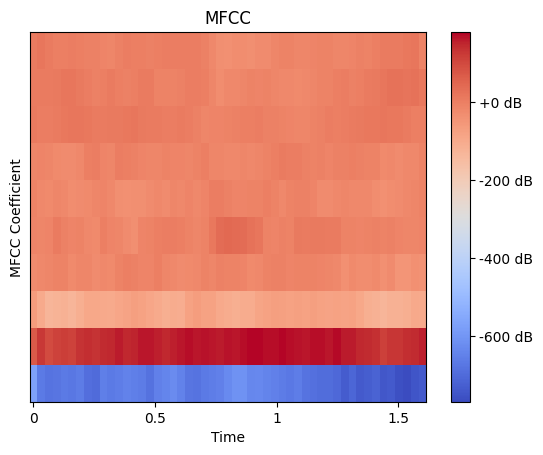

In [60]:
#for i in range(0, dataset_array[0].__len__()):
#    plot_mfcc(dataset_array[0][i])
plot_mfcc(dataset_array[0][0])

In [61]:
# Flatten the dataset array to a certain degree, but keep the inner 2D arrays holding MFCC.
X = np.concatenate(dataset_array, axis=0)
# Create labels for the dataset by copying the class index for each MFCC.
Y = np.concatenate([[i] * len(c) for i, c in enumerate(dataset_array)])

# Split up the data into training and testing data.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, train_size=0.8)

print(f"Train data shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (1824, 10, 51)
Train labels shape: (1824,)
Test data shape: (456, 10, 51)
Test labels shape: (456,)


In [77]:
# Add an "empty" color dimension for our data sets
x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)

In [85]:
len(dataset_classes)

3

In [86]:
# Creation of the sequential model and all layers

input_shape = x_train[0].shape
num_classes = len(dataset_classes)

sequential_model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = input_shape),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(units = num_classes, activation = "softmax")
])


In [87]:
sequential_model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])

In [88]:
history = sequential_model.fit(
    x = x_train,
    y = y_train,
    epochs = 32,
    batch_size = 32, 
    verbose = 1,
    validation_split = 0.2,    
)

Epoch 1/32


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 3)

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 3)


In [ ]:
def printHistory(history):
  epochs = len(history.history['loss']) # Collect the number of epochs run based on the amount of loss value under history.

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
printHistory(history)